In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src/bars')
from ImbalanceVolumeBars import ImbalanceVolumeBars

# 📈 Example: Applying Imbalance Volume Bars to NVDA

In this example, we apply the **Imbalance Volume Bars** (IVB) algorithm to one-minute OHLCV data from **NVDA**, covering a full month — **March 12, 2025 to April 11, 2025**.

This time period was deliberately selected due to its **elevated and unstable volatility**, providing a dynamic and high-pressure environment to assess the algorithm's robustness.

By observing how the algorithm constructs bars during both calm and turbulent phases, we aim to evaluate its adaptability compared to traditional time-based sampling.  
Such an evaluation helps determine whether the method captures market structure more effectively in **non-stationary or extreme regimes**.

In [2]:
nvda_time_bars = pd.read_csv('../data/nvda.csv', parse_dates=['date'], index_col='date')

# 🔷 Raw Data Representations
The chart below illustrates the minute-by-minute price change (`diff`) of NVDA during the examined period.
While not a formal volatility measure (e.g., standard deviation of returns), it serves as a visual proxy
for price instability and directional intensity.

The presence of multiple large spikes and bursts confirms that the Imbalance Volume Bar algorithm  was evaluated under highly dynamic market conditions.

In [3]:
close_values = nvda_time_bars.reset_index()['close']
volatility = close_values.diff()
moving_std = close_values.rolling(30).std()

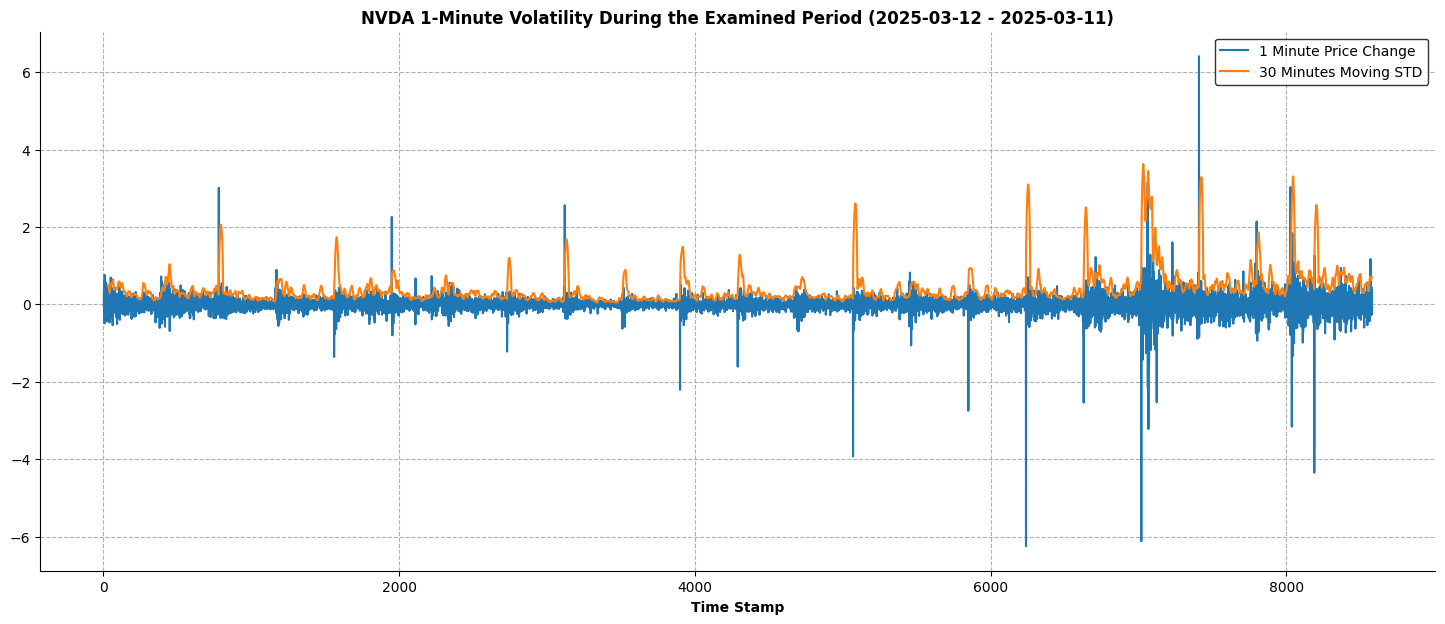

In [4]:
plt.figure(figsize=(18, 7))
plt.plot(volatility, label='1 Minute Price Change')
plt.plot(moving_std, label='30 Minutes Moving STD')
plt.xlabel('Time Stamp', weight='bold')
plt.legend(edgecolor='k')
plt.grid(ls='--')
plt.title('NVDA 1-Minute Volatility During the Examined Period (2025-03-12 - 2025-03-11)', weight='bold')
sns.despine()
plt.show()

# 📦 ImbalanceVolumeBars – Usage and Performance

The `ImbalanceVolumeBars` class automatically converts the input `pandas.DataFrame` into optimized NumPy arrays to achieve maximal computational efficiency.

Using the class involves two simple steps:

1. **Initialize the class** with the input data – relevant fields are preprocessed and stored in memory.  
2. **Call the `make_bars` method**, specifying the desired imbalance sensitivity via the `alpha` parameter.

The entire process is highly efficient and completes in a fraction of a second, as demonstrated in the example below.


In [5]:
ivb = ImbalanceVolumeBars(nvda_time_bars)

In [6]:
%%time
nvda_ivb = ivb.make_bars(alpha=.9)

CPU times: total: 328 ms
Wall time: 316 ms


### 📊 Imbalance Volume Bar Creation Below the Surface

The chart below illustrates the internal dynamics behind the construction of **Imbalance Volume Bars** for NVDA:

- **Imbalance Index** $(θ)$: Represents the signed volume imbalance at each tick, based on price direction.
- **Cumulative Imbalance** $(|Θ|)$: The running sum of $θ$, capturing directional pressure over time.
- **Dynamic Threshold**: An exponentially weighted moving threshold that determines when a bar should be closed.

A new bar is triggered whenever the **absolute cumulative imbalance** exceeds the **adaptive threshold**.  
These moments are marked in red, indicating **bar creation points** driven by significant directional volume pressure.

This visualization demonstrates how the method adapts bar frequency to market conditions — creating more bars in volatile periods, and fewer when the market is quiet.  
📌 **Note:** The x-axis in the plots represents relative bar positions rather than actual timestamps.

In [7]:
nvda_imbalance = ivb.imbalance
nvda_cumulative_imbalance = abs(ivb.cumulative_imbalance)
nvda_thresholds = ivb.thresholds
bar_creation_points = np.where(np.abs(nvda_cumulative_imbalance) > nvda_thresholds)[0]

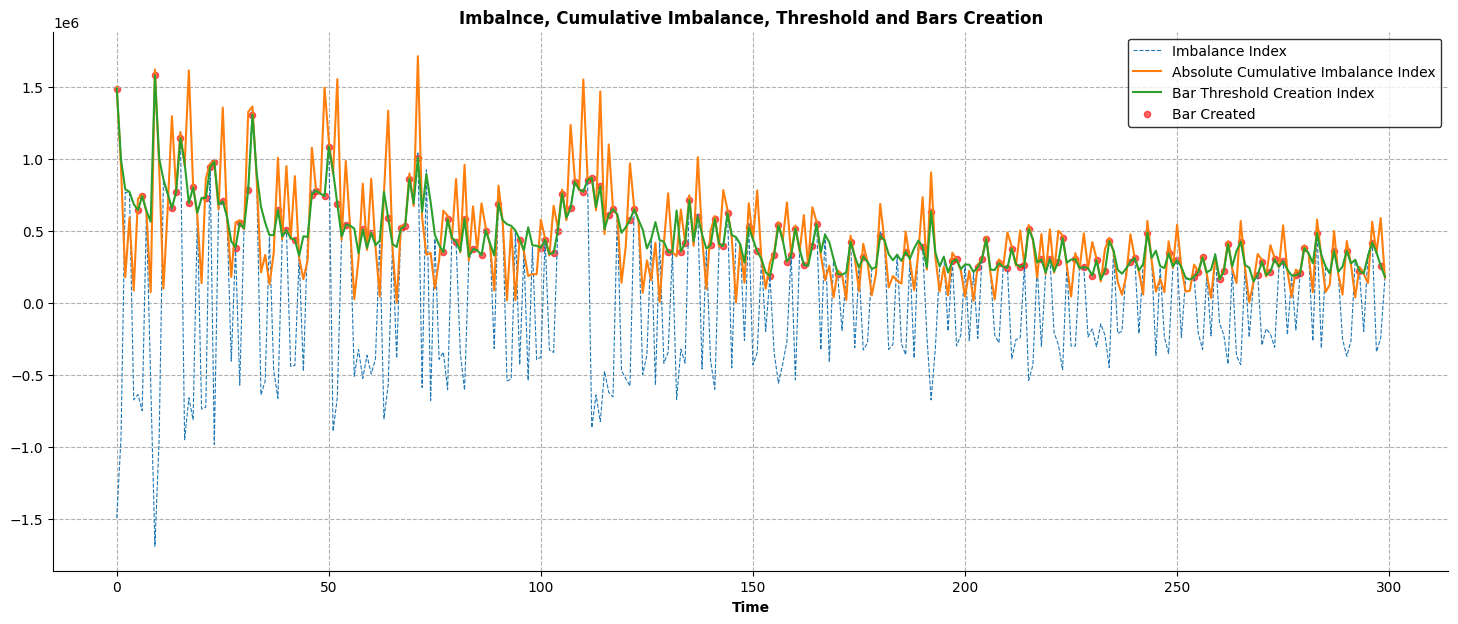

In [8]:
start_index = np.random.randint(len(nvda_ivb)-300)
end_index = start_index + 300

bar_creation_points_window = bar_creation_points[
    (bar_creation_points >= start_index) & (bar_creation_points < end_index)
]

plt.figure(figsize=(18,7))
plt.plot(nvda_imbalance[start_index:end_index],
         label='Imbalance Index',
         ls='--', lw=.8)

plt.plot(nvda_cumulative_imbalance[start_index:end_index],
         label='Absolute Cumulative Imbalance Index')

plt.plot(nvda_thresholds[start_index:end_index], 
         label='Bar Threshold Creation Index')

plt.scatter(
    bar_creation_points_window - start_index,
    nvda_thresholds[bar_creation_points_window],
    color='r', s=20, alpha=0.6, label='Bar Created'
)

plt.xlabel('Time', weight='bold')
plt.title('Imbalnce, Cumulative Imbalance, Threshold and Bars Creation', weight='bold')
plt.grid(ls='--')
plt.legend(edgecolor='k')
sns.despine()
plt.show()

### 📈 Close Price Comparison – Time Bars vs Volume Imbalance Bars

This chart compares the closing prices of NVDA on a selected trading day using two bar sampling techniques:

- **Time Bars (Raw Close)** – standard uniform 1-minute bars based on time intervals.
- **Volume Imbalance Bars (Volume Bar Close)** – dynamically sampled bars created only when a directional volume imbalance exceeds a dynamic threshold.

The goal of this comparison is to highlight how event-based sampling reacts differently to market activity.  
While time bars are generated at fixed intervals regardless of activity, volume imbalance bars adapt to actual trading flow, potentially capturing important price movements more precisely in periods of high activity and reducing noise during low-volume periods.

This visualization can help evaluate whether volume-based sampling captures more meaningful structural information in price movements.  
The code is based on a random index from the distribution space, and repeated execution allows viewing different dates.

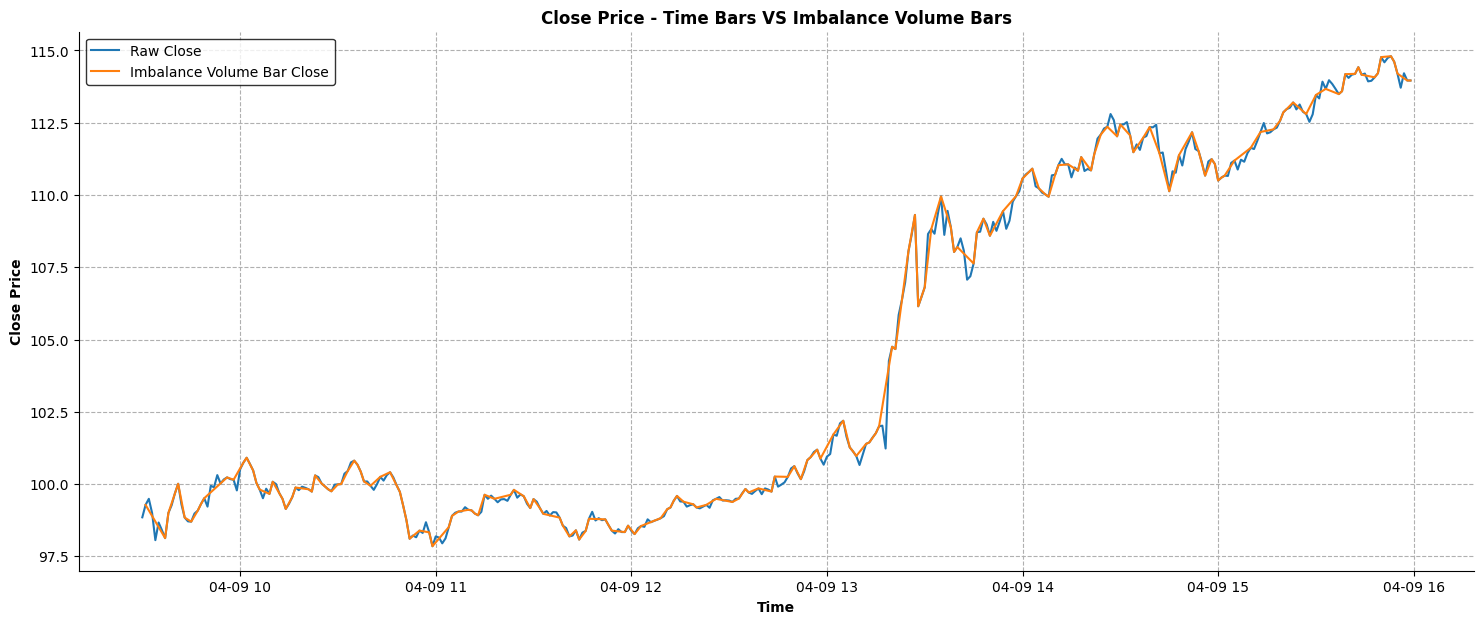

In [9]:
available_dates_nvda = nvda_time_bars.index.normalize().unique()

random_index = np.random.randint(len(available_dates_nvda))
valid_date = str(available_dates_nvda[random_index].date())
start = valid_date + ' 09:30:00'
end = valid_date + ' 16:00:00'

plt.figure(figsize=(18,7))
plt.plot(nvda_time_bars['close'].loc[start:end], label='Raw Close')
plt.plot(nvda_ivb['Close'].loc[start:end], label='Imbalance Volume Bar Close')
plt.xlabel('Time', weight='bold')
plt.ylabel('Close Price', weight='bold')
plt.title('Close Price - Time Bars VS Imbalance Volume Bars', weight='bold')
plt.legend(edgecolor='k')
plt.grid(ls='--')
sns.despine()
plt.show()

# 📈 Log-Returns Comparison – Time Bars vs. Imbalance Volume Bars

In the following analysis, we compare the log-returns generated by traditional time-based sampling (Time Bars) with those generated by volume-driven sampling (Imbalance Volume Bars, or IVB). As we will observe, IVB bars effectively reduce the noise introduced by uniform time intervals while preserving significant price movements and the core structure of market behavior.

Each time you run the code, a random time window is selected, allowing you to visualize and compare the log-returns under both sampling methods across different market conditions.  

📌 **Note:** The x-axis in the plots represents relative bar positions rather than actual timestamps.

Selected Random Start Datetime: 2025-04-02 13:58:00-04:00
Selected Random End Datetime: 2025-04-04 15:17:00-04:00


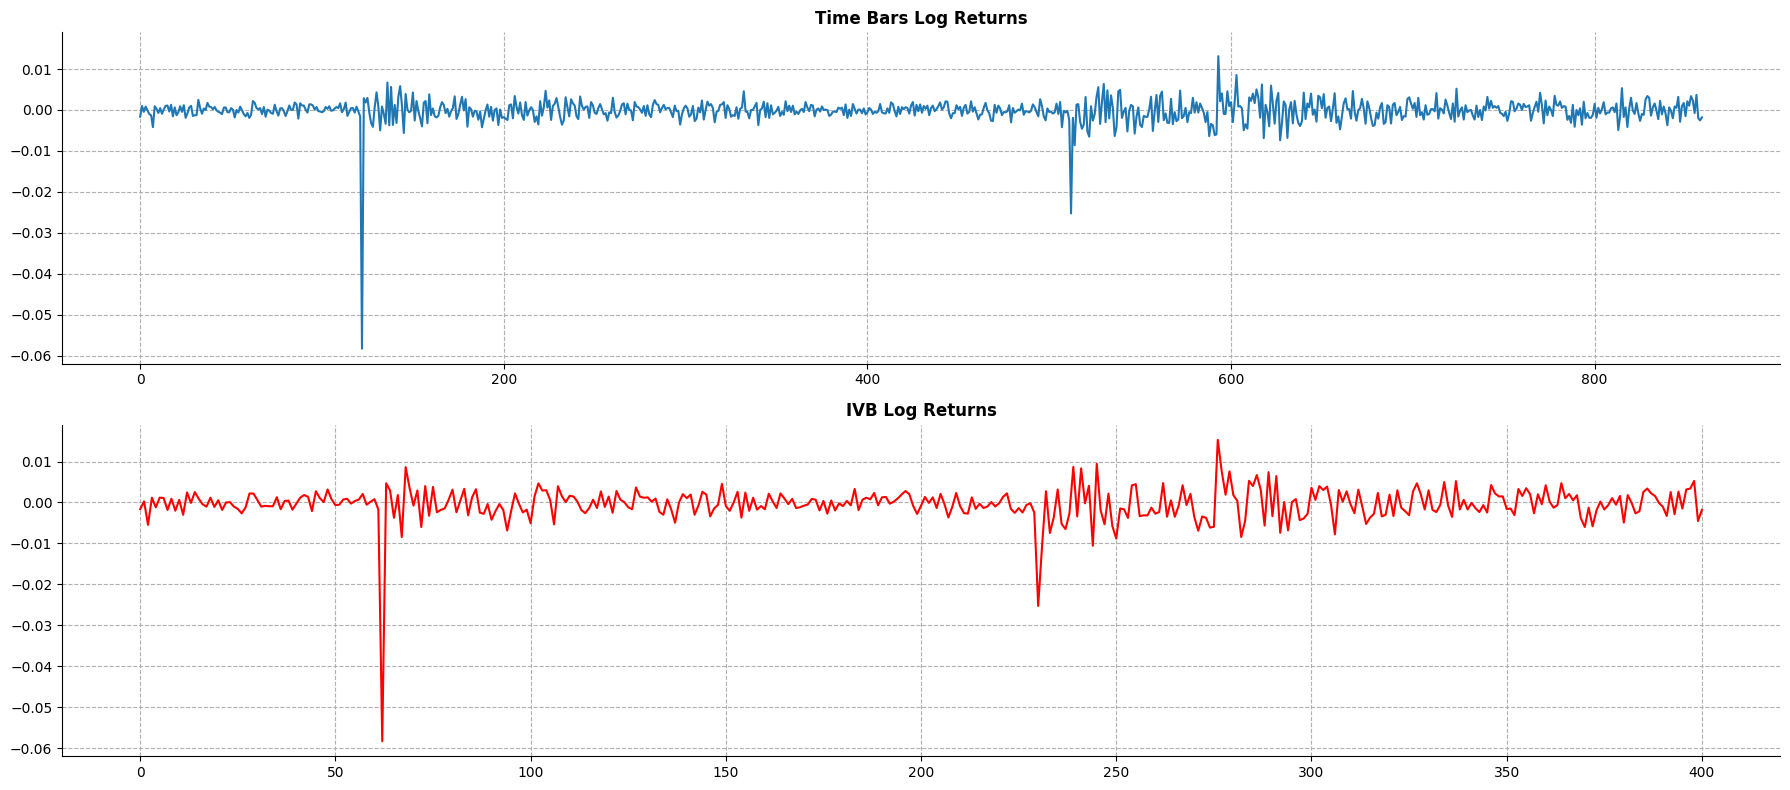

In [10]:
time_log_returns = np.log(nvda_time_bars['close'] / nvda_time_bars['close'].shift(1)).dropna()
ivb_log_returns = np.log(nvda_ivb['Close'] / nvda_ivb['Close'].shift(1)).dropna()

random_start = np.random.randint(len(nvda_ivb)-400)
possible_indexes = nvda_ivb.index
start_index = possible_indexes[random_start]
end_index = possible_indexes[random_start + 400]

time_log_returns = time_log_returns[start_index:end_index].values
ivb_log_returns = ivb_log_returns[start_index:end_index].values


print(f'Selected Random Start Datetime: {start_index}')
print(f'Selected Random End Datetime: {end_index}')

time_axis = pd.date_range(start=start_index, periods=400, freq='min')
fig, ax = plt.subplots(2,1, figsize=(18,8), sharey=True)
ax[0].plot(time_log_returns)
ax[0].set_title('Time Bars Log Returns', weight='bold')
ax[0].grid(ls='--')


ax[1].plot(ivb_log_returns,
          color='r')
ax[1].set_title('IVB Log Returns', weight='bold')
ax[1].grid(ls='--')


sns.despine()
plt.tight_layout()
plt.show()

## 📶 Log - Returns Distribution Comparisom

In [11]:
from scipy.stats import shapiro, ttest_ind, ks_2samp, levene, skew, kurtosis, norm

In [12]:
def compare_skew (series1, series2):
    n1, n2 = len(series1), len(series2)
    sk1, sk2 = skew(series1), skew(series2)
    se_sk1 = np.sqrt(6/n1)
    se_sk2 = np.sqrt(6/n2)

    z_skew = (sk1 - sk2) / np.sqrt(se_sk1**2 + se_sk2**2)
    p_skew = 2 * (1 - norm.cdf(abs(z_skew)))

    return z_skew, p_skew


def compare_kurt (series1, series2):
    n1, n2 = len(series1), len(series2)
    kurt1, kurt2 = kurtosis(series1, fisher=True), kurtosis(series2, fisher=True)
    se_kurt1 = np.sqrt(24 / n1)
    se_kurt2 = np.sqrt(24 / n2)

    z_kurt = (kurt1 - kurt2) / np.sqrt(se_kurt1**2 + se_kurt2**2)
    p_kurt = 2 * (1-norm.cdf(abs(z_kurt)))

    return z_kurt, p_kurt

In [13]:
def compare_distributions(series1, series2, name1='series1', name2='series2'):
    results = []

    def log(text, stat, p):
        sig = '✅ Significant' if p < 0.05 else '❌ Not Significant'
        return f'{text:<25} | stat = {stat:.4f} | p = {p:.4f} | {sig}'

    s1 = pd.Series(series1).dropna()
    s2 = pd.Series(series2).dropna()

    results.append('📊 Distribution Comparison\n')

    # 1) Shapiro-Wilk Test for normality
    stat1, p1 = shapiro(s1)
    stat2, p2 = shapiro(s2)
    results.append(log(f'Shapiro-Wilk Normality Test ({name1})', stat1, p1))
    results.append(log(f'Shapiro-Wilk Normality Test ({name2})', stat2, p2))

    # 2) KS Test for distribution comparison
    stat, p = ks_2samp(s1, s2)
    results.append(log('Kolmogorov-Smirnov Distributions Equality', stat, p))

    # 3) T-Test for means comparison
    stat, p = ttest_ind(s1, s2, equal_var=False)
    results.append(log("Welch's T-Test Means Equality", stat, p))

    # 4) Levene's test for variance comparison
    stat, p = levene(s1, s2)
    results.append(log("Levene's Test Variance Equality", stat, p))

    # 5) Skeweness comparison
    stat, p = compare_skew(s1, s2)
    results.append(log('Skewness Equality', stat, p))

    # 6) Kurtosis comparison
    stat, p = compare_kurt(s1, s2)
    results.append(log('Kurtosis Equality', stat, p))

    return '\n'.join(results)

In [14]:
print(compare_distributions(time_log_returns, ivb_log_returns, 'time bars', 'ivb bars'))

📊 Distribution Comparison

Shapiro-Wilk Normality Test (time bars) | stat = 0.6207 | p = 0.0000 | ✅ Significant
Shapiro-Wilk Normality Test (ivb bars) | stat = 0.6712 | p = 0.0000 | ✅ Significant
Kolmogorov-Smirnov Distributions Equality | stat = 0.1162 | p = 0.0011 | ✅ Significant
Welch's T-Test Means Equality | stat = 0.8471 | p = 0.3973 | ❌ Not Significant
Levene's Test Variance Equality | stat = 24.6914 | p = 0.0000 | ✅ Significant
Skewness Equality         | stat = -19.0438 | p = 0.0000 | ✅ Significant
Kurtosis Equality         | stat = 292.6778 | p = 0.0000 | ✅ Significant


C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


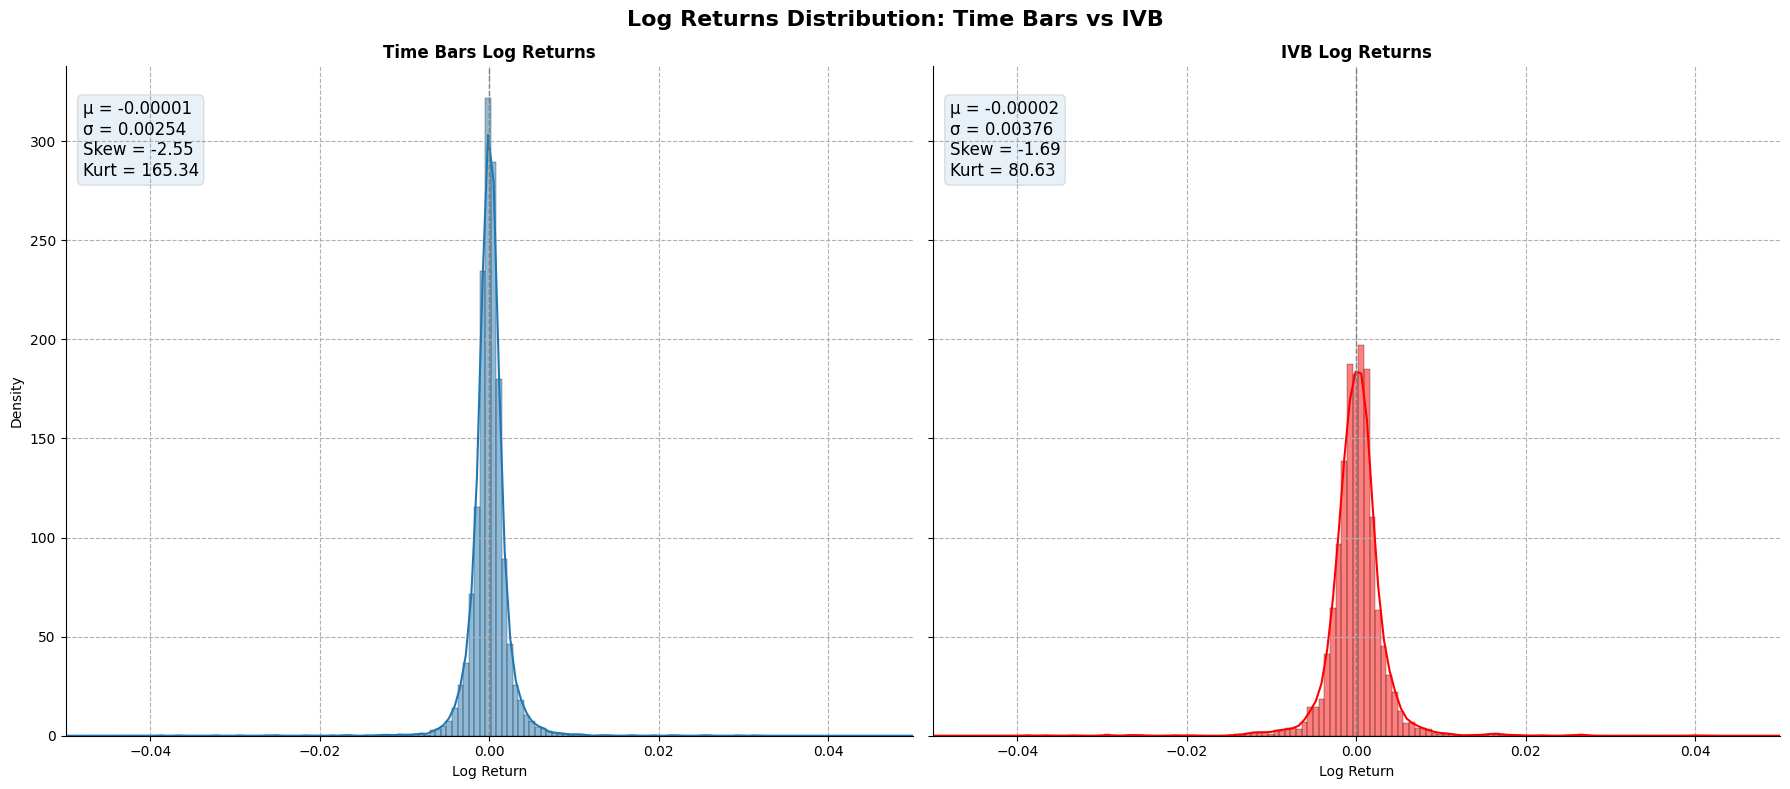

In [15]:
time_log_returns = np.log(nvda_time_bars['close'] / nvda_time_bars['close'].shift(1)).dropna()
ivb_log_returns = np.log(nvda_ivb['Close'] / nvda_ivb['Close'].shift(1)).dropna()

def describe(series):
    return {
        'Mean': np.mean(series),
        'Std': np.std(series),
        'Skew': skew(series),
        'Kurtosis': kurtosis(series)
    }

time_stats = describe(time_log_returns)
ivb_stats = describe(ivb_log_returns)



fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
xlim = (-0.05, 0.05)

sns.histplot(time_log_returns, ax=ax[0], bins=200, kde=True, stat='density')
ax[0].set_title('Time Bars Log Returns', weight='bold')
ax[0].set_xlim(xlim)
ax[0].set_xlabel('Log Return')
ax[0].set_ylabel('Density')
ax[0].grid(ls='--')
ax[0].axvline(0, color='gray', linestyle='--', lw=1)
ax[0].text(0.02, 0.95, 
           f"μ = {time_stats['Mean']:.5f}\nσ = {time_stats['Std']:.5f}\nSkew = {time_stats['Skew']:.2f}\nKurt = {time_stats['Kurtosis']:.2f}", 
           transform=ax[0].transAxes, verticalalignment='top', fontsize=12, bbox=dict(boxstyle="round", alpha=0.1))

sns.histplot(ivb_log_returns, ax=ax[1], bins=200, kde=True, stat='density', color='r')
ax[1].set_title('IVB Log Returns', weight='bold')
ax[1].set_xlim(xlim)
ax[1].set_xlabel('Log Return')
ax[1].set_ylabel('Density')
ax[1].grid(ls='--')
ax[1].axvline(0, color='gray', linestyle='--', lw=1)
ax[1].text(0.02, 0.95, 
           f"μ = {ivb_stats['Mean']:.5f}\nσ = {ivb_stats['Std']:.5f}\nSkew = {ivb_stats['Skew']:.2f}\nKurt = {ivb_stats['Kurtosis']:.2f}", 
           transform=ax[1].transAxes, verticalalignment='top', fontsize=12, bbox=dict(boxstyle="round", alpha=0.1))

fig.suptitle('Log Returns Distribution: Time Bars vs IVB', fontsize=16, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()

## Log - Returns Stationarity Comparison

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
def compare_stationarity(series1, series2, name1='series1', name2='series2'):
    """Takes the original series (series1) and the resampled series (series2) and compares stationarity"""
    statio1 = adfuller(series1)
    p1 = statio1[1]
    
    statio2 = adfuller(series2)
    p2 = statio2[1]

    if p1>p2:
        return(f'✅ Stationary improved.\n pvalue1 ={ p1}\n pvalue = pvalue{p2}')
    else:
        return(f'❌ stationary was not improved.\npvalue1 = {p1} \npvalue2 = {p2} ')

In [18]:
print(compare_stationarity(time_log_returns, ivb_log_returns))

❌ stationary was not improved.
pvalue1 = 3.969981026422003e-29 
pvalue2 = 3.698963505252266e-23 


## 📊 Log - Returns Autocorrelation Comparison

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

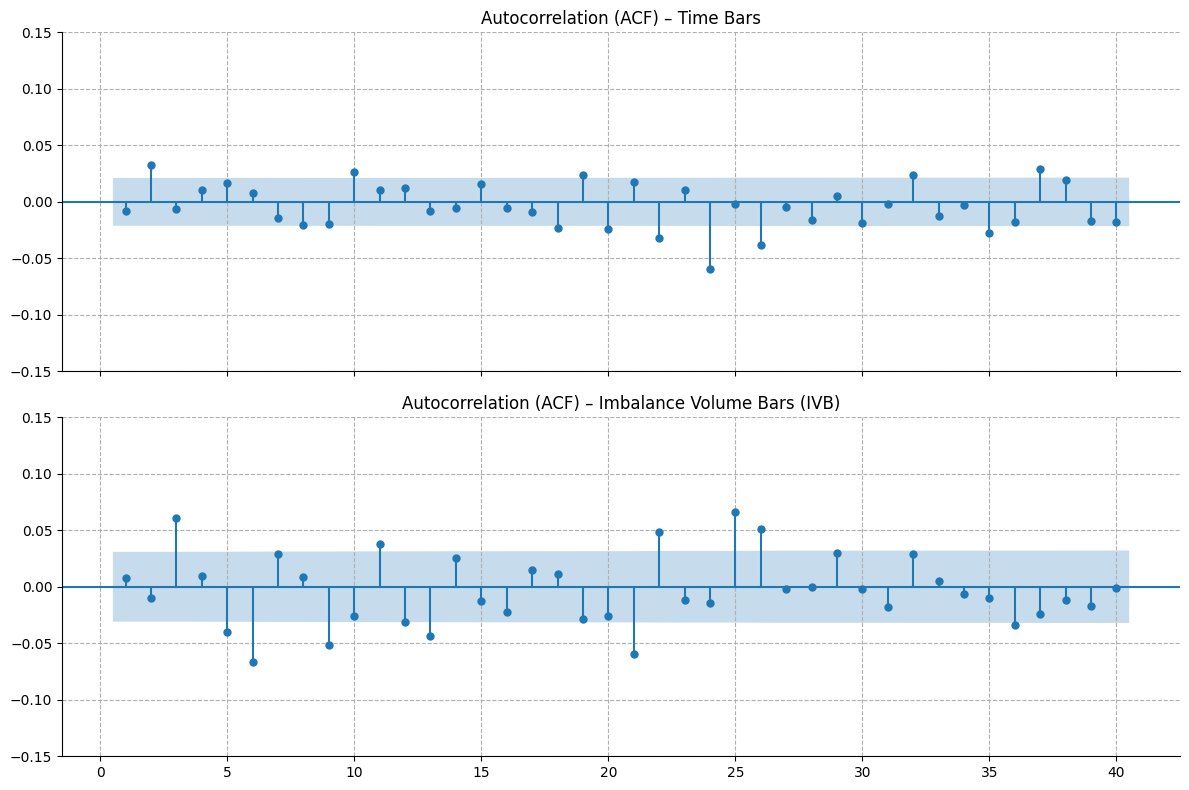

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
y_lim = (-0.15, 0.15)

plot_acf(time_log_returns, lags=40, zero=False, ax=ax[0])
ax[0].set_ylim(y_lim)
ax[0].set_title("Autocorrelation (ACF) – Time Bars")
ax[0].grid(ls='--')

plot_acf(ivb_log_returns, lags=40, zero=False, ax=ax[1])
ax[1].set_ylim(y_lim)
ax[1].set_title("Autocorrelation (ACF) – Imbalance Volume Bars (IVB)")
ax[1].grid(ls='--')

sns.despine()
plt.tight_layout()
plt.show()

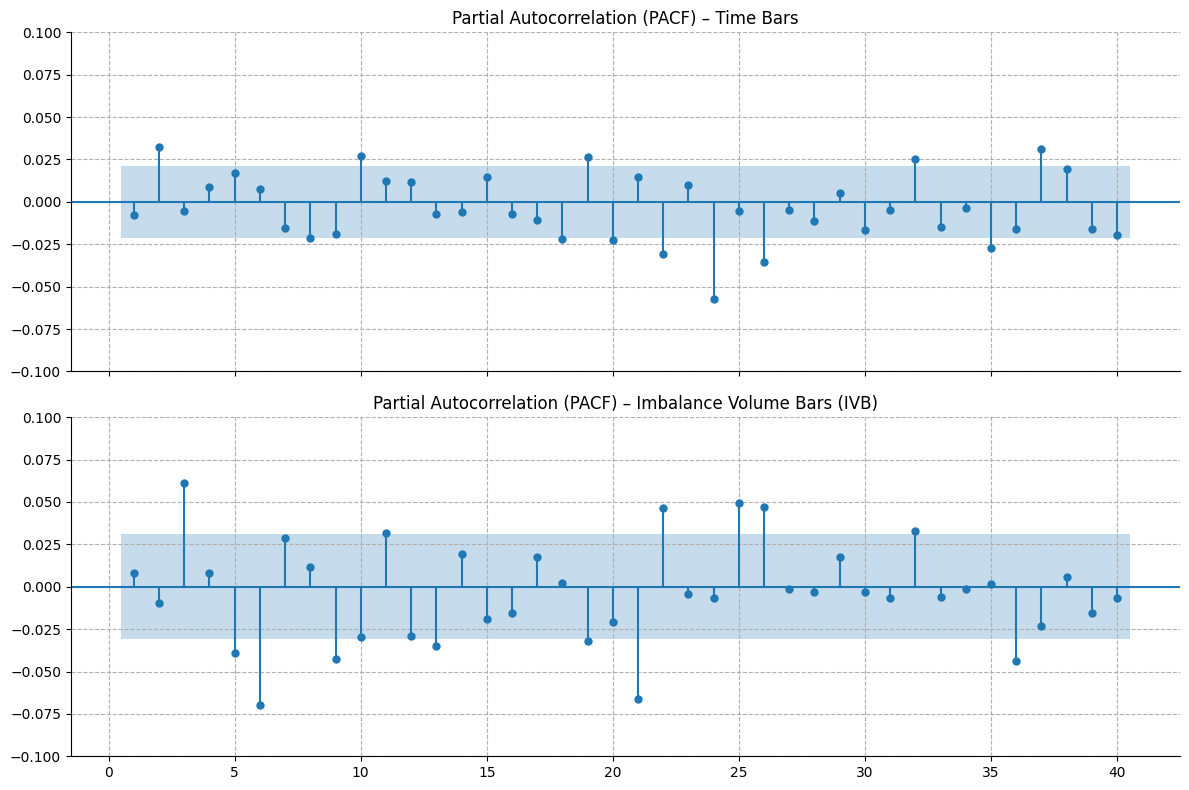

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
y_lim = (-0.1, 0.1)

plot_pacf(time_log_returns, lags=40, zero=False, ax=ax[0])
ax[0].set_ylim(y_lim)
ax[0].set_title("Partial Autocorrelation (PACF) – Time Bars")
ax[0].grid(ls='--')

plot_pacf(ivb_log_returns, lags=40, zero=False, ax=ax[1])
ax[1].set_ylim(y_lim)
ax[1].set_title("Partial Autocorrelation (PACF) – Imbalance Volume Bars (IVB)")
ax[1].grid(ls='--')

sns.despine()
plt.tight_layout()
plt.show()

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_time = acorr_ljungbox(time_log_returns, lags=20, return_df=True)
lb_ivb = acorr_ljungbox(ivb_log_returns, lags=20, return_df=True)

results = pd.DataFrame({
    "Lag": lb_time.index,
    "Time Bars Stat": lb_time["lb_stat"].values,
    "Time Bars p-value": lb_time["lb_pvalue"].values,
    "IVB Stat": lb_ivb["lb_stat"].values,
    "IVB p-value": lb_ivb["lb_pvalue"].values
})

results

,Lag,Time Bars Stat,Time Bars p-value,IVB Stat,IVB p-value
0,1,0.523522,0.469343,0.246542,6.195203e-01
1,2,9.533924,0.008506,0.632066,7.290353e-01
2,3,9.833825,0.020033,15.746530,1.278059e-03
3,4,10.701758,0.030128,16.108093,2.877496e-03
4,5,13.055664,0.022863,22.576903,4.065825e-04
5,6,13.583378,0.034653,40.477967,3.668769e-07
6,7,15.391277,0.031298,43.884563,2.249934e-07
7,8,19.097954,0.014344,44.160636,5.305460e-07
8,9,22.387669,0.007728,55.038323,1.197643e-08
9,10,28.460687,0.001523,57.773999,9.534441e-09


## ✍️ Statistical Insights: Time Bars vs. Imbalance Volume Bars (IVB)

This section presents key statistical insights into the distributional characteristics of log-returns under two sampling schemes: traditional Time Bars and Imbalance Volume Bars (IVB).

1. **Normality:**  
   Both distributions deviate from normality according to the Shapiro–Wilk test. However, it is important to note that this test becomes increasingly sensitive with large sample sizes, often rejecting the null hypothesis even for minor deviations from normality.

2. **Mean:**  
   The means of both return series are very close to zero, which aligns with expectations for short-term returns in efficient markets.

3. **Variance:**  
   Both distributions exhibit low standard deviations. However, the standard deviation of the IVB sample is slightly but significantly higher. This difference likely reflects the IVB method’s ability to capture meaningful price movements while filtering out noise, which dilutes volatility in time-based sampling.

4. **Skewness:**  
   The IVB sample shows significantly lower (i.e., less negative) skewness compared to the Time Bar sample. This suggests that IVB is more robust to asymmetry caused by sharp downward movements. While Time Bars continue sampling even in the absence of meaningful activity—thereby capturing drops that may not reflect true market behavior—IVB tends to sample only when substantial volume imbalances occur, resulting in a more balanced distribution.

5. **Kurtosis:**  
   IVB also exhibits substantially lower kurtosis, indicating fewer extreme values and a less sharply peaked distribution. This supports the notion that Time Bars artificially concentrate observations around zero through numerous "quiet" bars, leading to heavy-tailed distributions. In contrast, IVB reflects only genuine market activity, producing a distribution that is closer in shape to a normal distribution.

6. **Stationarity:**  
Both Time Bars and IVB samples exhibit strong stationarity according to the Augmented Dickey-Fuller (ADF) test, with extremely low p-values (on the order of \$(10^{-23}$\) and \$(10^{-29}\$)). While statistically differences exist between these p-values, they are practically negligible. Thus, both series can be confidently treated as stationary, and the minor statistical difference observed does not have practical implications for further analysis.

7. **Autocorrelation Dynamics:**   
The autocorrelation and partial autocorrelation functions clearly suggest that the IVB return series exhibits a more random and memory-less structure compared to its time-based counterpart. However, the Ljung–Box test reports higher cumulative autocorrelation in the IVB series. Interpreting this apparent contradiction requires a deeper statistical investigation beyond the scope of the current work. This observation is therefore presented as an open question, inviting further reflection and potential reinterpretation by future researchers and practitioners.

---

**Conclusion:**  
These findings support the effectiveness of IVB as a sampling method for financial time series, especially in contexts where noise reduction and the preservation of meaningful price dynamics are critical.

## 🔬 Directions for Future Work

This project aimed to propose a consistent methodology for implementing Imbalance Volume Bars (IVB) and analyzing their statistical implications. As noted, the analysis was conducted on a single financial instrument and does not seek to generalize the findings. Therefore, future research could explore broader applications of the method—across different time intervals, market regimes, and assets with varying statistical behaviors.

In addition, the implementation in this project did not include the tick imbalance average as originally suggested in López de Prado's work. In internal experiments, incorporating this feature resulted in numerical instability and inconsistent sampling outcomes. However, a stable and thoughtful integration of the tick imbalance mean could enhance the method’s sensitivity to meaningful market activity.

Another promising direction involves improving the initialization procedure of the imbalance threshold. In the current implementation, a fixed threshold was used. Future improvements may involve adaptive or dynamic initialization schemes—potentially based on recent market behavior—to increase the precision and responsiveness of the sampling process.
